<a href="https://colab.research.google.com/github/ggfard/human-honeyguide-communication-model/blob/main/Copy_of_Updating_H_H_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Synchrony started at t = 23.31 s
Synchrony exit triggered at t = 123.31 s


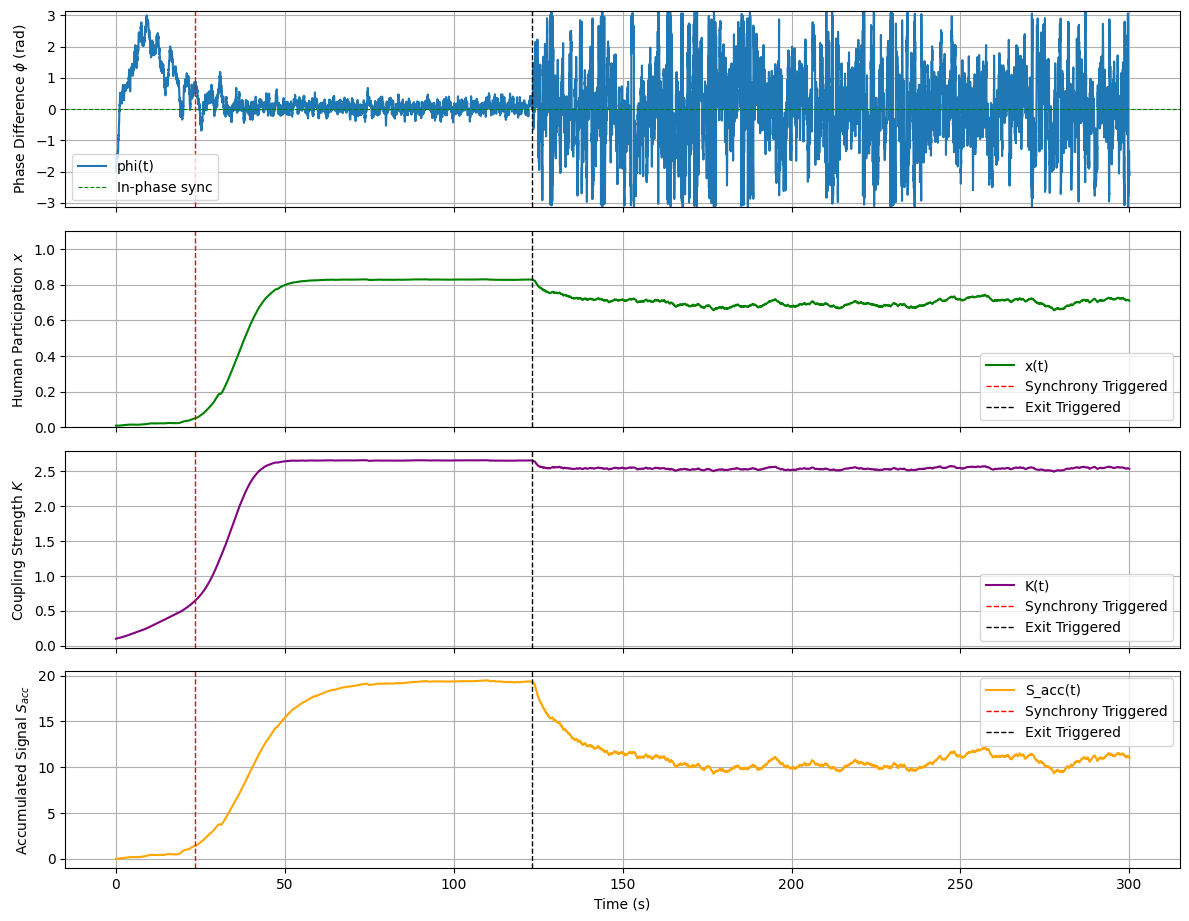

In [1]:
# This is a model in-progress to simulate human-honeyguide communication

import numpy as np
import matplotlib.pyplot as plt


# Updating the model to address:
# 1. a Gradual Increase in Task Progress (x) during the engagement phase
# 2. introducing temporary (damped) oscilations in coupling (K)

# Main changes from the old model:
# Phase Difference (dϕ/dt): No change
# Human Participation (dx/dt): The growth term (1+αcos(ϕ)) is now cos²(ϕ), making growth strictly dependent on good synchrony (cos²(ϕ) is highest when ϕ is near zero).
#                              A new decay term, -x, has been added, which causes participation to wane if the synchrony-driven growth is not strong enough to sustain it.
# Dynamics Coupling (dK/dt): This equation has been completely reformulated. The growth of K is now driven by a positive feedback term Kcos²(ϕ), so coupling reinforces itself during synchrony.
#                            It is now inhibited by two terms that depend on x (-βx(2K_max - K) and -δxK), which will cause coupling to decrease as the task progresses.
# Accumulated Signal (dS_acc/dt): The growth of S_acc is now driven by the coupling strength K instead of participation x.
#                                 The sharp threshold Max(0, cos(ϕ) - thresh_cos) has been replaced by the smoother cos²(ϕ) term.

# increasing thresh_cos
# decreasing r


# Model Parameters
delta_w = 0.4      # Difference in intrinsic frequencies (rad/s)
K_max = 3.0        # Maximum coupling strength (rad/s)
beta = 0.2         # Growth rate for K
delta = 0.3        # Decay rate for K
r = 0.3            # Growth rate for x
#alpha = 0.95
G = 0.75           # Gain for the accumulated signal
thresh_cos = 0.85  # Threshold for detecting synchrony
tau_sacc = 10.0    # Time constant for the decay of S_acc (s)

T_sync_duration = 100.0       # Required duration of synchrony to trigger exit (s)
noise_strength_base = 0.5     # Standard noise level during interaction
noise_strength_high = 3.0     # High noise level to break synchrony lock
desync_tolerance_time = 5.0   # Time (s) phi can be out of synchrony before sync_time_accumulator resets

# Simulation Setup
dt = 0.02          # Time step (s)
T = 300            # Total simulation time (s), increased to see the full cycle
n_steps = int(T / dt)
time = np.linspace(0, T, n_steps)

# Initial Conditions
phi = np.zeros(n_steps)
x = np.zeros(n_steps)
K = np.zeros(n_steps)
S_acc = np.zeros(n_steps)

phi[0] = np.pi * (2 * np.random.rand() - 1)
x[0] = 0.01
K[0] = 0.1
S_acc[0] = 0.0

# State variables for Exit Mechanism
desync_timer = 0.0
sync_time_accumulator = 0.0

sync_triggered = False  # Flag to ensure it's recorded only once
sync_time = -1          # Stores the time when synchrony onset is detected

exit_triggered = False
exit_time = -1

# new
gamma = 0.05

current_noise_strength = noise_strength_base

# Simulation Loop
for t in range(n_steps - 1):
    # Check for continuous synchrony
    if np.cos(phi[t]) > thresh_cos:
        sync_time_accumulator += dt
        desync_timer = 0.0 # Reset desync timer if synchrony is re-established
        #print (f"sync_time_accumulator is accumulating at t = {time[t]:2f} s")

    else:
        desync_timer += dt # Increment desync timer if out of synchrony
        # Only reset sync_time_accumulator if desynchronization lasts longer than tolerance
        if desync_timer >= desync_tolerance_time:
            # Reset timer if synchrony is broken
            sync_time_accumulator = 0
            #print ('reset!')

    # Check if sustained synchrony (engagement phase) has started
    if sync_time_accumulator >= T_sync_duration and not sync_triggered:
        sync_triggered = True
        sync_time = time[t] - T_sync_duration
        print(f"Synchrony started at t = {sync_time:.2f} s")


    # Trigger the exit mechanism if conditions are met
    if sync_time_accumulator >= T_sync_duration and not exit_triggered:
        exit_triggered = True
        current_noise_strength = noise_strength_high
        exit_time = time[t]
        print(f"Synchrony exit triggered at t = {exit_time:.2f} s")


    dphi_dt = delta_w - 2 * K[t] * np.sin(phi[t])

    # Old model equations
    #dx_dt = r * S_acc[t] * x[t] * (1 - x[t]) * (1 + alpha * np.cos(phi[t]))
    #dK_dt = beta * x[t] * np.cos(phi[t]) * (K_max - K[t]) - delta * K[t]
    #max_term = np.maximum(0, np.cos(phi[t]) - thresh_cos)
    #dS_acc_dt = G * max_term - (S_acc[t] / tau_sacc)

    # New equations
    cos_phi_sq = np.cos(phi[t])**2
    dx_dt = r * x[t] * (1 - x[t]) * cos_phi_sq - (x[t] * gamma)
    dK_dt = beta * x[t] * (2 * K_max - K[t]) - delta * x[t] * K[t] + K[t] * cos_phi_sq * (x[t] * gamma) #- K[t]
    dS_acc_dt = G * K[t] * cos_phi_sq - (S_acc[t] / tau_sacc)

    noise = current_noise_strength * np.random.randn() * np.sqrt(dt)
    phi[t+1] = phi[t] + dt * dphi_dt + noise
    phi[t+1] = (phi[t+1] + np.pi) % (2 * np.pi) - np.pi

    x[t+1] = x[t] + dt * dx_dt
    K[t+1] = K[t] + dt * dK_dt
    S_acc[t+1] = S_acc[t] + dt * dS_acc_dt

    x[t+1] = np.clip(x[t+1], 0, 1)
    K[t+1] = np.clip(K[t+1], 0, K_max)
    S_acc[t+1] = np.maximum(0, S_acc[t+1]) # quality/history of communication cannot be negative

#  Visualization
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
#fig.suptitle('Simulation of human honeyguide interaction phases', fontsize=16)

axs[0].plot(time, phi, label='phi(t)')
axs[0].set_ylabel('Phase Difference $\phi$ (rad)')
axs[0].set_ylim(-np.pi, np.pi)
axs[0].axhline(0, color='g', linestyle='--', linewidth=0.8, label='In-phase sync')
if sync_time != -1:
    axs[0].axvline(sync_time, color='r', linestyle='--', linewidth=1)#, label='Synchrony Triggered')
if exit_triggered:
    axs[0].axvline(exit_time, color='k', linestyle='--', linewidth=1)#, label='Exit Triggered')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(time, x, label='x(t)', color='g')
axs[1].set_ylabel('Human Participation $x$')
axs[1].set_ylim(0, 1.1)
if sync_triggered:
    axs[1].axvline(sync_time, color='r', linestyle='--', linewidth=1, label='Synchrony Triggered')
if exit_triggered:
    axs[1].axvline(exit_time, color='k', linestyle='--', linewidth=1, label='Exit Triggered')
axs[1].legend()
axs[1].grid(True)


axs[2].plot(time, K, label='K(t)', color='purple')
axs[2].set_ylabel('Coupling Strength $K$')
if sync_triggered:
    axs[2].axvline(sync_time, color='r', linestyle='--', linewidth=1, label='Synchrony Triggered')
if exit_triggered:
    axs[2].axvline(exit_time, color='k', linestyle='--', linewidth=1, label='Exit Triggered')
axs[2].legend()
axs[2].grid(True)


axs[3].plot(time, S_acc, label='S_acc(t)', color='orange')
axs[3].set_ylabel('Accumulated Signal $S_{acc}$')
axs[3].set_xlabel('Time (s)')
if sync_triggered:
    axs[3].axvline(sync_time, color='r', linestyle='--', linewidth=1, label='Synchrony Triggered')
if exit_triggered:
    axs[3].axvline(exit_time, color='k', linestyle='--', linewidth=1, label='Exit Triggered')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])


**Model Issues:**
1. x is still increasing early on in the engangement phase.
2. x does not decay much in the exit phase
3. k is going up smoothly without any oscilations which is not ideal
4. k does not decay much in the exit phase

## A slightly improved version below

Synchrony started at t = 123.01 s
Synchrony exit triggered at t = 223.01 s


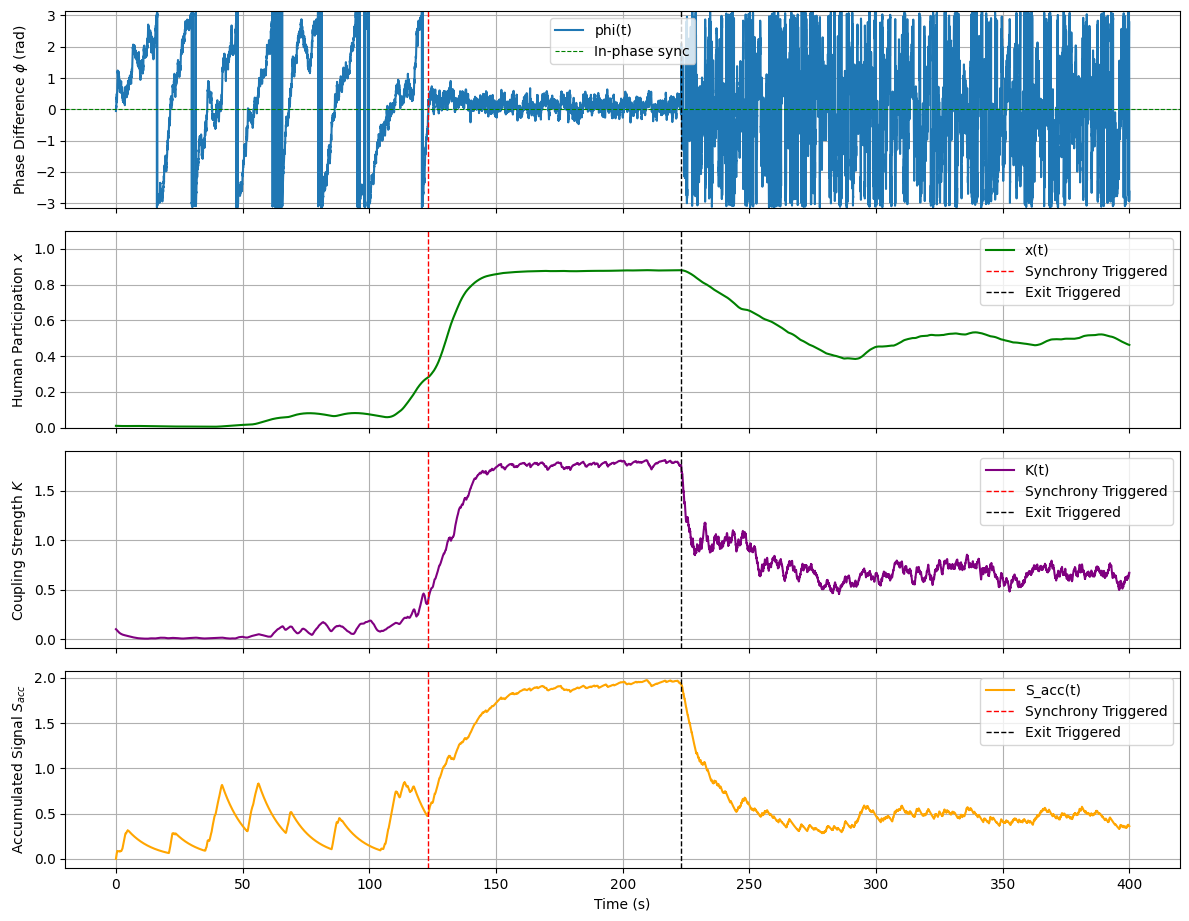

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# Changes to the equations:

# 1. To smoothen the abrupt growth in x, I brought back S_acc in the x's growth rate so it depends on the accumulated history of good synchrony,
# not just its instantaneous presence (cos(phi) close to 1).
# When synchrony breaks, S_acc will decay, decreasing the positive drive for x, allowing x to gradually decrease if cooperation is no longer useful.

# 2. Reverted to a form similar to the old K equation but incorporating cos_phi_sq to the growth term and adding a factor of 2 to the K_max
# The growth of K is now tied to both x and the effective synchrony cos_phi_sq.
# During disengagement, when x starts to decrease (due to S_acc dropping) and cos_phi_sq becomes noisy/low, the positive growth term for K diminishes significantly.
# The persistent decay term −δ⋅K(t) then dominates, causing K to damp down.
# The interaction between growth term and constant decay can lead to transient oscillations or temporary dips in K.

# 3. Used the old S_acc equation but removed the factor of x from the growth term.
# The max_term means S_acc only accumulates when synchrony is above a certain threshold, which is what we want.
# S_acc also directly weakens the positive growth term for x during periods of inefficient cooperation.
# Since S_acc eventually drops significantly during the exit phase (as cosϕ is no longer consistently above thresh_cos),
# the primary positive drive for x diminishes, allowing the x*gamma term to pull x down.

# Parameters:

# adjusted thresh_cos to see all phases
# decreased r (min is ~0.3 to see all phases)
# slightly increased delta and G, and gamma


# Model Parameters
delta_w = 0.4      # Difference in intrinsic frequencies (rad/s)
K_max = 3.0        # Maximum coupling strength (rad/s)
beta = 0.2         # Growth rate for K
delta = 0.4       # Decay rate for K
r = 0.3      # Growth rate for x
#alpha = 0.95
G = 0.85
thresh_cos = 0.75
tau_sacc = 10.0    # Time constant for the decay of S_acc (s)

# Parameters for Exit
T_sync_duration = 100.0       # Required duration of synchrony to trigger exit (s)
noise_strength_base = 0.5
noise_strength_high = 3.0
desync_tolerance_time = 5.0    # Time (s) phi can be out of synchrony before sync_time_accumulator resets


# Simulation Setup
dt = 0.02          # Time step (s)
T = 400            # Total simulation time (s), increased to see the full cycle
n_steps = int(T / dt)
time = np.linspace(0, T, n_steps)

# Initial Conditions
phi = np.zeros(n_steps)
x = np.zeros(n_steps)
K = np.zeros(n_steps)
S_acc = np.zeros(n_steps)

phi[0] = np.pi * (2 * np.random.rand() - 1)
x[0] = 0.01
K[0] = 0.1
S_acc[0] = 0.0

# State variables for Exit Mechanism
desync_timer = 0.0
sync_time_accumulator = 0.0

sync_triggered = False # Flag to ensure it's recorded only once
sync_time = -1  # Stores the time when synchrony onset is detected

exit_triggered = False
exit_time = -1

# new
gamma = 0.07

current_noise_strength = noise_strength_base

# Simulation Loop
for t in range(n_steps - 1):
    # Check for continuous synchrony
    if np.cos(phi[t]) > thresh_cos:
        sync_time_accumulator += dt
        desync_timer = 0.0 # Reset desync timer if synchrony is re-established
        #print (f"sync_time_accumulator is accumulating at t = {time[t]:2f} s")

    else:
        desync_timer += dt # Increment desync timer if out of synchrony
        # Only reset sync_time_accumulator if desynchronization lasts longer than tolerance
        if desync_timer >= desync_tolerance_time:
            # Reset timer if synchrony is broken
            sync_time_accumulator = 0
            #print ('reset!')

    # Check if sustained synchrony (engagement phase) has started
    if sync_time_accumulator >= T_sync_duration and not sync_triggered:
        sync_triggered = True
        sync_time = time[t] - T_sync_duration
        print(f"Synchrony started at t = {sync_time:.2f} s")


    # Trigger the exit mechanism if conditions are met
    if sync_time_accumulator >= T_sync_duration and not exit_triggered:
        exit_triggered = True
        current_noise_strength = noise_strength_high
        exit_time = time[t]
        print(f"Synchrony exit triggered at t = {exit_time:.2f} s")


    dphi_dt = delta_w - 2 * K[t] * np.sin(phi[t])

    # adding S_acc influence to the X dynamics
    #dx_dt = r * S_acc[t] * x[t] * (1 - x[t]) * (1 + alpha * np.cos(phi[t]))
    #dK_dt = beta * x[t] * np.cos(phi[t]) * (K_max - K[t]) - delta * K[t]
    #max_term = np.maximum(0, np.cos(phi[t]) - thresh_cos)
    #dS_acc_dt = G * max_term - (S_acc[t] / tau_sacc)

    # new equations
    cos_phi_sq = np.cos(phi[t])**2
    dx_dt = r * x[t] * (1 - x[t]) * S_acc[t] - (x[t] * gamma) # cos_phi_sq
    dK_dt = beta * x[t] * cos_phi_sq * (2 * K_max - K[t]) - delta * K[t]
    #dK_dt = beta * x[t] * ( K_max - K[t]) - delta * x[t] * K[t] + K[t] * cos_phi_sq * (x[t] * gamma) #- K[t]
    max_term = np.maximum(0, np.cos(phi[t]) - thresh_cos)
    dS_acc_dt = G * max_term - (S_acc[t] / tau_sacc)
    #dS_acc_dt = G * K[t] * cos_phi_sq - (S_acc[t] / tau_sacc)

    noise = current_noise_strength * np.random.randn() * np.sqrt(dt)
    phi[t+1] = phi[t] + dt * dphi_dt + noise
    phi[t+1] = (phi[t+1] + np.pi) % (2 * np.pi) - np.pi

    x[t+1] = x[t] + dt * dx_dt
    K[t+1] = K[t] + dt * dK_dt
    S_acc[t+1] = S_acc[t] + dt * dS_acc_dt

    x[t+1] = np.clip(x[t+1], 0, 1)
    K[t+1] = np.clip(K[t+1], 0, K_max)
    #S_acc[t+1] = np.maximum(0, S_acc[t+1]) # quality/history of communication cannot be negative

#  Visualization
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
#fig.suptitle('Simulation with Emergent Exit from Synchrony', fontsize=16)

axs[0].plot(time, phi, label='phi(t)')
axs[0].set_ylabel('Phase Difference $\phi$ (rad)')
axs[0].set_ylim(-np.pi, np.pi)
axs[0].axhline(0, color='g', linestyle='--', linewidth=0.8, label='In-phase sync')
if sync_time != -1:
    axs[0].axvline(sync_time, color='r', linestyle='--', linewidth=1)#, label='Synchrony Triggered')
if exit_triggered:
    axs[0].axvline(exit_time, color='k', linestyle='--', linewidth=1)#, label='Exit Triggered')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(time, x, label='x(t)', color='g')
axs[1].set_ylabel('Human Participation $x$')
axs[1].set_ylim(0, 1.1)
if sync_triggered:
    axs[1].axvline(sync_time, color='r', linestyle='--', linewidth=1, label='Synchrony Triggered')
if exit_triggered:
    axs[1].axvline(exit_time, color='k', linestyle='--', linewidth=1, label='Exit Triggered')
axs[1].legend()
axs[1].grid(True)


axs[2].plot(time, K, label='K(t)', color='purple')
axs[2].set_ylabel('Coupling Strength $K$')
if sync_triggered:
    axs[2].axvline(sync_time, color='r', linestyle='--', linewidth=1, label='Synchrony Triggered')
if exit_triggered:
    axs[2].axvline(exit_time, color='k', linestyle='--', linewidth=1, label='Exit Triggered')
axs[2].legend()
axs[2].grid(True)


axs[3].plot(time, S_acc, label='S_acc(t)', color='orange')
axs[3].set_ylabel('Accumulated Signal $S_{acc}$')
axs[3].set_xlabel('Time (s)')
if sync_triggered:
    axs[3].axvline(sync_time, color='r', linestyle='--', linewidth=1, label='Synchrony Triggered')
if exit_triggered:
    axs[3].axvline(exit_time, color='k', linestyle='--', linewidth=1, label='Exit Triggered')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])


**Improvements:**
1. x and k now decay in the exit phase
2. K oscilates instead of smooth increase simulating a more natural coupling strength growth with transient periods of short disengagement
